In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim 
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score , precision_score , recall_score , f1_score
from torch.utils.data import DataLoader, TensorDataset


In [2]:
# Import the model (assuming Models/models.py has HybridModel class)
# at the top of your file
import sys
import os

In [4]:
# Go two levels up from this file to reach project root
import os
current_dir = os.getcwd()
import sys
sys.path.append(r"E:\ITSolera\HMS\Structural_Health_Monitoring_System")

from Models.models import HybridModel  # adjust path if needed


In [5]:

#load

v2_data = np.load("../Data/Processed/Training_Prepared_Data/V2_dataset.npz")
X2 = v2_data["X"]
y2 = v2_data["y"]

In [6]:
#convert to tensors
X = torch.tensor(X2, dtype=torch.float32)
y = torch.tensor(y2, dtype=torch.long)

In [7]:

#Split 
X_train, X_temp , y_train ,y_temp = train_test_split(X, y , test_size = 0.2 , stratify=y , random_state = 42)

#Split
X_val , X_test , y_val , y_test = train_test_split(X_temp , y_temp , test_size = 0.5 , random_state=42 , stratify=y_temp)

In [9]:
# Save test data in compressed npz format
np.savez_compressed(
    "../Data/Processed/Testing_Prepared_Data/V2_featured_test.npz",
    X_test=X_test.numpy(),
    y_test=y_test.numpy()
)

In [10]:
# Create DataLoader with TesorDataset
batch_size = 8
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val , y_val)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset , batch_size=batch_size , shuffle=False)

In [11]:
# Best Params: {'cnn_channels': 32, 'lstm_hidden': 32, 'lstm_layers': 2, 'lr': 0.00017366050532753203, 'batch_size': 16}
# Best CV Accuracy: 0.9604505037737048s


model = HybridModel(
    input_channels=19,
    cnn_channels=32,
    lstm_hidden=32,
    lstm_layers=2,
    num_classes=4
)

In [12]:

# Early Stopping Helper
class EarlyStopping:
    def __init__(self, patience=5, delta=0.0):
        self.patience = patience
        self.delta = delta
        self.best_score = None
        self.counter = 0
        self.early_stop = False
        
        
    def __call__(self, val_loss):
        score = -val_loss  # we minimize val_loss
        if self.best_score is None:
            self.best_score = score
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.counter = 0


In [13]:

# Training Loop
def train_with_early_stopping(model, train_loader, val_loader  , epochs = 50 , patience=5):
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.00017)
    early_stopper = EarlyStopping(patience=patience)
    
    
    train_losses =[]
    val_losses = []
    
    
    for epoch in range(epochs):
        
        # ----------Training----------
        model.train()
        running_loss = 0
        for x_batch, y_batch in train_loader:
            
            optimizer.zero_grad()
            outputs = model(x_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * x_batch.size(0)
        epoch_train_loss =running_loss / len(train_loader.dataset)
        train_losses.append(epoch_train_loss)
        
        
        
        # --- Validation ---
        model.eval()
        val_running_loss = 0
        y_true, y_pred = [], []
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)
                val_running_loss += loss.item() * X_batch.size(0)

                preds = torch.argmax(outputs, dim=1)
                y_true.extend(y_batch.cpu().numpy())
                y_pred.extend(preds.cpu().numpy())
                
        epoch_val_loss = val_running_loss / len(val_loader.dataset)
        val_losses.append(epoch_val_loss)
        
        acc = accuracy_score(y_true, y_pred)
        prec = precision_score(y_true, y_pred, average="weighted", zero_division=0)
        rec = recall_score(y_true, y_pred, average="weighted", zero_division=0)
        f1 = f1_score(y_true, y_pred, average="weighted", zero_division=0)
        
        print(f"Epoch {epoch+1}/{epochs} | "
              f"Train Loss: {epoch_train_loss:.4f} | Val Loss: {epoch_val_loss:.4f} | "
              f"Acc: {acc:.4f} | Prec: {prec:.4f} | Rec: {rec:.4f} | F1: {f1:.4f}")
        
        
        # Early stopping check
        early_stopper(epoch_val_loss)
        if early_stopper.early_stop:
            print("Early stopping triggered.")
            break
        
        
        
            # --- Plot Loss ---
    plt.figure(figsize=(8,5))
    plt.plot(train_losses, label="Train Loss")
    plt.plot(val_losses, label="Val Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training & Validation Loss")
    plt.legend()
    plt.show()

    return model


Epoch 1/50 | Train Loss: 1.1039 | Val Loss: 0.6958 | Acc: 0.8134 | Prec: 0.7570 | Rec: 0.8134 | F1: 0.7818
Epoch 2/50 | Train Loss: 0.5046 | Val Loss: 0.3722 | Acc: 0.8731 | Prec: 0.8165 | Rec: 0.8731 | F1: 0.8423
Epoch 3/50 | Train Loss: 0.3430 | Val Loss: 0.2804 | Acc: 0.8806 | Prec: 0.8327 | Rec: 0.8806 | F1: 0.8508
Epoch 4/50 | Train Loss: 0.2718 | Val Loss: 0.3515 | Acc: 0.8806 | Prec: 0.8898 | Rec: 0.8806 | F1: 0.8566
Epoch 5/50 | Train Loss: 0.2309 | Val Loss: 0.2294 | Acc: 0.9179 | Prec: 0.9275 | Rec: 0.9179 | F1: 0.9011
Epoch 6/50 | Train Loss: 0.2147 | Val Loss: 0.1475 | Acc: 0.9403 | Prec: 0.9406 | Rec: 0.9403 | F1: 0.9390
Epoch 7/50 | Train Loss: 0.1894 | Val Loss: 0.1309 | Acc: 0.9552 | Prec: 0.9569 | Rec: 0.9552 | F1: 0.9553
Epoch 8/50 | Train Loss: 0.1688 | Val Loss: 0.1404 | Acc: 0.9254 | Prec: 0.9293 | Rec: 0.9254 | F1: 0.9227
Epoch 9/50 | Train Loss: 0.1573 | Val Loss: 0.1087 | Acc: 0.9552 | Prec: 0.9574 | Rec: 0.9552 | F1: 0.9547
Epoch 10/50 | Train Loss: 0.1545 | Va

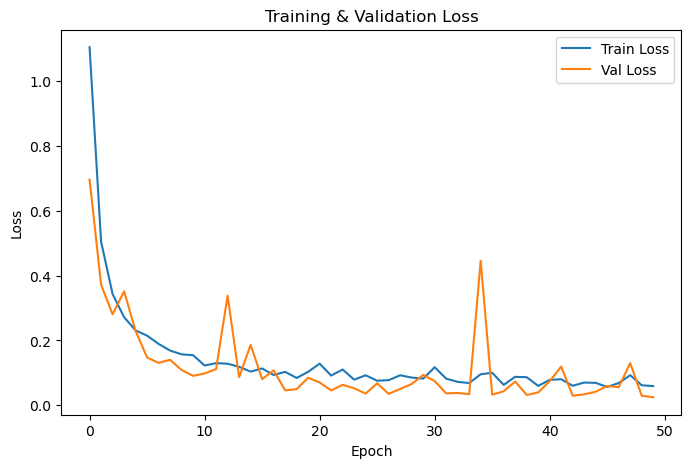

HybridModel(
  (cnn): Sequential(
    (0): Conv1d(19, 32, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): ReLU()
    (2): Conv1d(32, 32, kernel_size=(3,), stride=(1,), padding=(1,))
    (3): ReLU()
    (4): AdaptiveAvgPool1d(output_size=32)
  )
  (lstm): LSTM(32, 32, num_layers=2, batch_first=True, bidirectional=True)
  (attention): Attention(
    (attn): Linear(in_features=64, out_features=1, bias=True)
  )
  (fc): Linear(in_features=64, out_features=4, bias=True)
)

In [14]:

# model = HybridModel(input_channels=1, cnn_channels=32, lstm_hidden=64, lstm_layers=1, num_classes=4).to(device)
train_with_early_stopping(model, train_loader, val_loader, epochs=50, patience=7)


In [16]:

#uncomment the one you trained the model .
torch.save(model.state_dict() , "../Models/Trained_models/V2_Best_model.pth") # Acc: 0.9776
# torch.save(model.state_dict() , "Models/Trained_models/V2_model.pth") #Acc: 0.9291